# <center> Sample code for reconstruction of a hologram stack </center>

This script works as a sample for the reconstruction of hologram stacks acquired from an area of interest. The input is [a stack of images](https://zenodo.org/uploads/15222400) saved as a gatan digital micrograph (.dm4) file. The reconstruction steps are as follows:

1) Selecting the holography parameters - For this step we take the FFT of the base holograms. We select the sideband of interest using butterworth filters. In this script there are 2 filters, 1 circular filter for the sand band and 1 line filter. Once the filters are applied to the FFT, the sideband is translated to the center to obtain the amplitude and phase spectrum. The output from this step will be a stack of complex images.

2) Stack alignment - The drift between the first image of the stack and the other images was calculated by cross correlation and compensated to subpixel precision. The amplitude spectrum of a small region of interest was used for calculating the cross correction and the correction is done to the complex images. The biprism drift results in a phase shift which is compensated using eigenvalue formulations. The output is a single complex image corrected for sample and biprism drift.

3) Visualization and other corrections  - A region of interest is selected where the  phase ramp and offsets need to be corrected. The ramp is calculated and corrected for and the result is visualized.

In [1]:
%matplotlib widget

In [2]:
import os

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.restoration import unwrap_phase
from skimage.transform import rotate
from skimage.measure import block_reduce

import empyre as emp

from libertem.api import Context
from libertem.udf.raw import PickUDF
from libertem_holo.udf.reconstr import HoloReconstructUDF

from libertem_holo.base.filters import (
    clipped, disk_aperture, butterworth_disk, butterworth_line,
)
from libertem_holo.base.utils import (
    estimate_sideband_position, estimate_sideband_size, freq_array, HoloParams, get_slice_fft, fft_shift_coords,
    remove_phase_ramp,
)
from libertem_holo.base.reconstr import phase_offset_correction
from libertem_holo.base.align import align_stack, ImageCorrelator, stack_alignment_quality

### Required Functions

In [3]:
ctx = Context()

In [4]:
def clipped_minmax(arr):
    clipped_arr = clipped(arr)
    return np.min(clipped_arr), np.max(clipped_arr)


def plot_mag_induction(mean_phase_norm_crop, axis, clipper=0.1, binning=1):
    mean_phase_norm_crop = block_reduce(mean_phase_norm_crop[::-1, :], (binning, binning), np.mean)
    clipped_frame = clipped(mean_phase_norm_crop)
    vmin, vmax = np.min(mean_phase_norm_crop), np.max(mean_phase_norm_crop)
    
    # Represent the unwrap phase image with the 'field' class
    phase_field = emp.fields.Field(data=mean_phase_norm_crop, scale=1, vector=False)
    
    # Display the curl
    cmap = emp.vis.colors.cmaps.cyclic_classic
    emp.vis.colorvec(phase_field.curl().clip(vmax=clipper), vmin=vmin, vmax=vmax, cmap=cmap, origin='lower', axis=axis)
    
    # Display the cosine contours
    emp.vis.cosine_contours(phase_field, gain=3, origin='lower', axis=axis)
    emp.vis.colorwheel(cmap=cmap, axis=axis)

## Data set

Before continuing, download the file called [100 deg C.dm4](https://zenodo.org/records/15222400/files/100%20deg%20C.dm4?download=1) from https://zenodo.org/uploads/15222400 and put it into the same folder as this notebook. For example using `wget`:

```bash
$ wget -O "100 deg C.dm4" https://zenodo.org/records/15222400/files/100%20deg%20C.dm4?download=1
```

/cachedata/alex/source/LiberTEM/src/libertem/io/dataset/dm_single.py:283: RuntimeWarning: Unrecognized image format Unknown, DM tags may be parsed incorrectly
  warnings.warn(
/cachedata/alex/source/LiberTEM/src/libertem/io/dataset/base/partition.py:75: RuntimeWarning: dataset contains fewer frames than specified partitions, setting num_partitions == num_frames == 10 to avoid creating empty partitions
  warnings.warn(


Text(0.5, 1.0, 'First hologram')

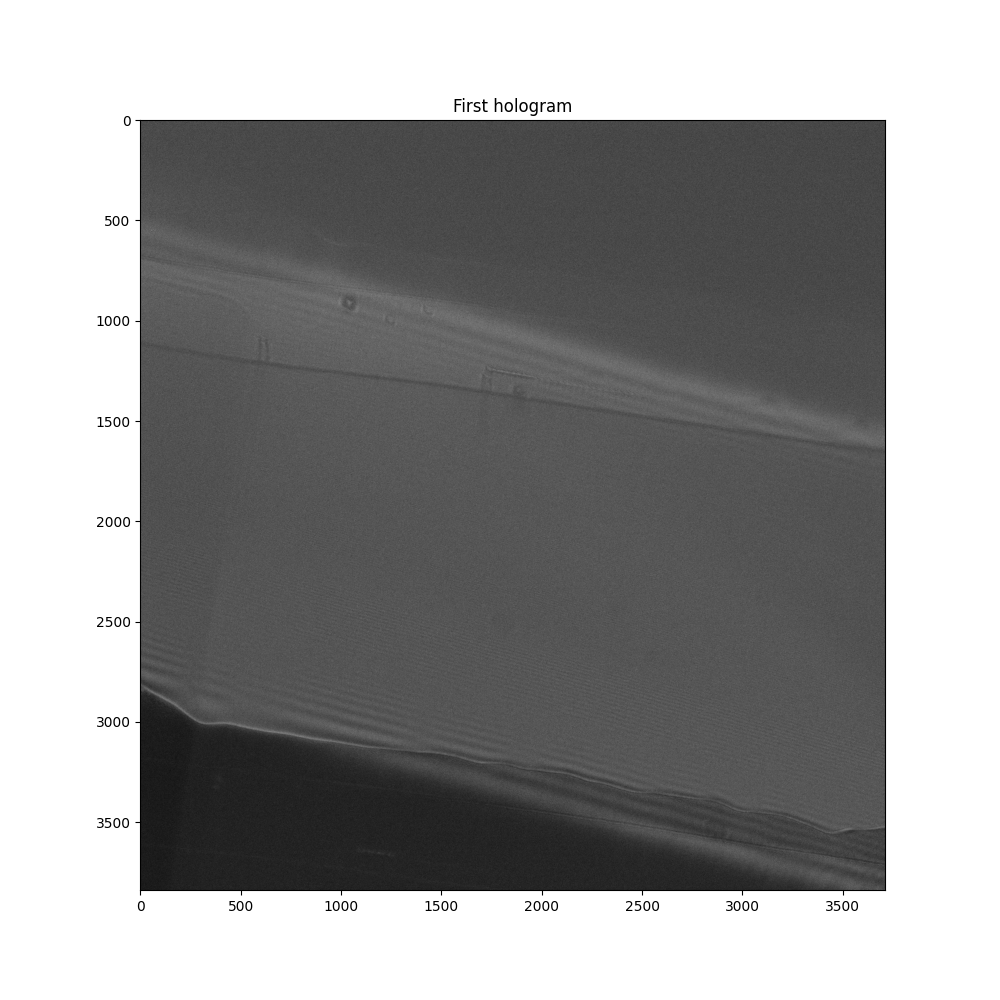

In [5]:
path = "./100 deg C.dm4"

ds_obj = ctx.load("dm", path=path)

def pick(idx, dataset=ds_obj):
    roi = np.zeros((dataset.shape[0],), dtype=bool)
    roi[idx] = True
    frame = ctx.run_udf(dataset=dataset, udf=PickUDF(), roi=roi)['intensity'].data[0]
    return frame

first_frame = pick(0)

clipped_frame = clipped(first_frame, sigma=6)
vmin, vmax = np.min(clipped_frame), np.max(clipped_frame)

fig, ax = plt.subplots(nrows=1, figsize=(10, 10))
ax.imshow(first_frame, vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title("First hologram")

## Step 1: Selecting the holography parameters

Here we apply 2 filters (1) Circular butterworth filter for the sideband and (2) Line filter for the center to side band streak in the fft

### Side band selection and filtering on one hologram

In [6]:
def pad_to_shape(arr, shape):
    pad_y = (
        (shape[0] - arr.shape[0])//2,
        (shape[0] - arr.shape[0])//2,
    )
    pad_x = (
        (shape[1] - arr.shape[1])//2,
        (shape[1] - arr.shape[1])//2,
    )
    return np.pad(arr, (pad_y, pad_x))

In [7]:
from libertem_holo.base.utils import other_sb

The side band position selected is x=2051, y=1192 (or x=1659 y=2646)


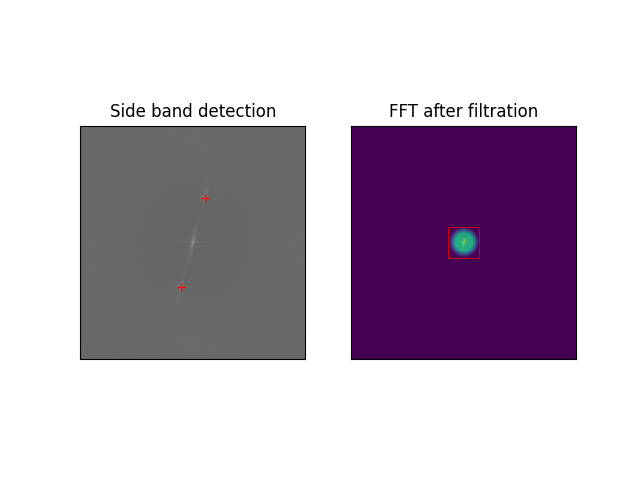

In [8]:
# size of the FFT image, also size of final image:
out_shape = (512, 512)

holo_params = HoloParams.from_hologram(
    first_frame, 
    out_shape=out_shape,
    sb_size=150,
)
fft_frame = np.fft.fft2(first_frame)
fft_slice = get_slice_fft(out_shape=holo_params.out_shape, sig_shape=first_frame.shape)
sb_pos_shifted = fft_shift_coords(holo_params.sb_position_int, shape=first_frame.shape)
other_sb_pos = fft_shift_coords(other_sb(holo_params.sb_position_int, first_frame.shape), shape=first_frame.shape)
fft_frame_rolled = np.roll(fft_frame, holo_params.sb_position_int, axis=(0, 1))
fft_frame_crop = np.fft.ifftshift(np.fft.fftshift(fft_frame_rolled)[fft_slice])

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.fft.fftshift(np.log1p(np.abs(fft_frame))), cmap='grey')
ax[0].plot(sb_pos_shifted[1], sb_pos_shifted[0], 'r+')
ax[0].plot(other_sb_pos[1], other_sb_pos[0], 'r+')
ax[0].set_title("Side band detection")
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].imshow(pad_to_shape(np.log1p(np.abs(np.fft.fftshift(holo_params.aperture * fft_frame_crop))), fft_frame.shape))
ax[1].set_title("FFT after filtration")
ax[1].set_yticks([])
ax[1].set_xticks([])
print(f"The side band position selected is x={sb_pos_shifted[1]}, y={sb_pos_shifted[0]} (or x={other_sb_pos[1]} y={other_sb_pos[0]})")

rect = patches.Rectangle(
   (fft_slice[1].start, fft_slice[0].start),
    fft_slice[1].stop - fft_slice[1].start,
    fft_slice[0].stop - fft_slice[0].start,
    linewidth=0.5,
    edgecolor='red',
    facecolor='none',
)
ax[1].add_patch(rect)

### Reconstruction of hologram stack to complex image stack

In [9]:
holo_obj = ctx.run_udf(
    dataset=ds_obj, udf=HoloReconstructUDF(out_shape=out_shape, sb_position=holo_params.sb_position, aperture=holo_params.aperture)
)
holo_wav = holo_obj['wave'].data  # This is the stack of reconstructed complex images

Text(0.5, 1.0, 'Phase (unwrapped)')

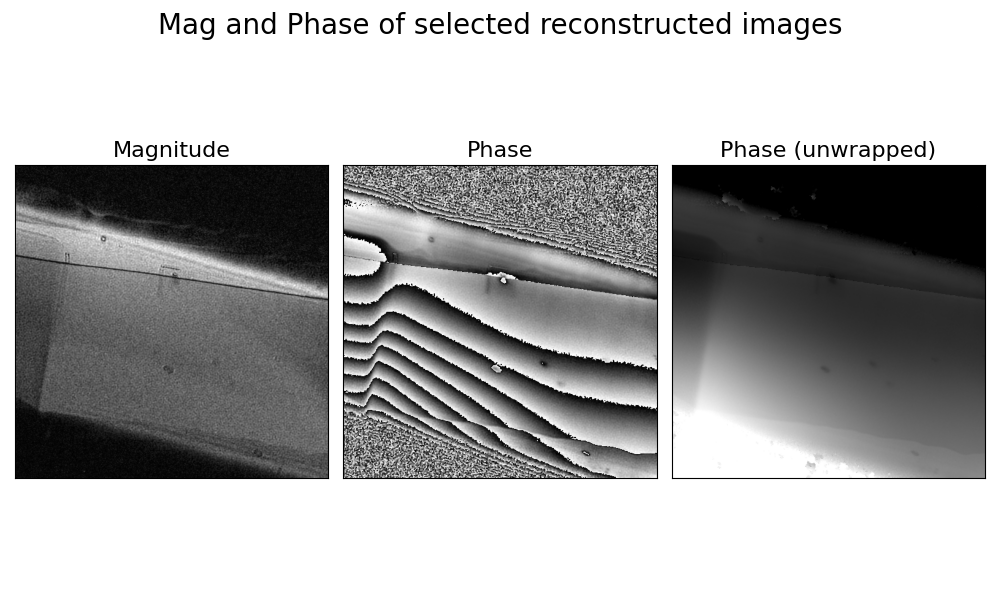

In [10]:
# Plotting one of the images
i = 0 # index to plot

fig, ax = plt.subplots(ncols=3, figsize=(10, 6))
fig.suptitle("Mag and Phase of selected reconstructed images", fontsize=20)
fig.set_layout_engine('tight')

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(np.abs(holo_obj['wave'].data[i]), cmap='grey')
ax[0].set_title("Magnitude", fontsize=16)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow((np.angle(holo_obj['wave'].data[i])), cmap='grey')
ax[1].set_title("Phase", fontsize=16)

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(unwrap_phase(np.angle(holo_obj['wave'].data[i])), cmap='grey', vmax=48, vmin=-10)
ax[2].set_title("Phase (unwrapped)", fontsize=16)

## Step 2: Stack alignment - correcting for sample drift and biprism drift

### sample drift correction

In [11]:
drift_roi = np.s_[50:234, 50:300]  # change to a different slice if the there are artifacts that prevent proper alignment

In [12]:
first_holo = holo_wav[0]

align_crop = first_holo[drift_roi]
vmin, vmax = clipped_minmax(np.abs(align_crop))

amp_stack = np.abs(holo_wav)

correlator = ImageCorrelator(binning=1, upsample_factor=10, normalization='phase')

# aligned_stack is a stack of complex images after compensation for sample drift
aligned_stack, shifts, _, _ = align_stack(
    stack=amp_stack[(...,) + drift_roi],
    wave_stack=holo_wav,
    static=None,
    correlator=correlator,
)

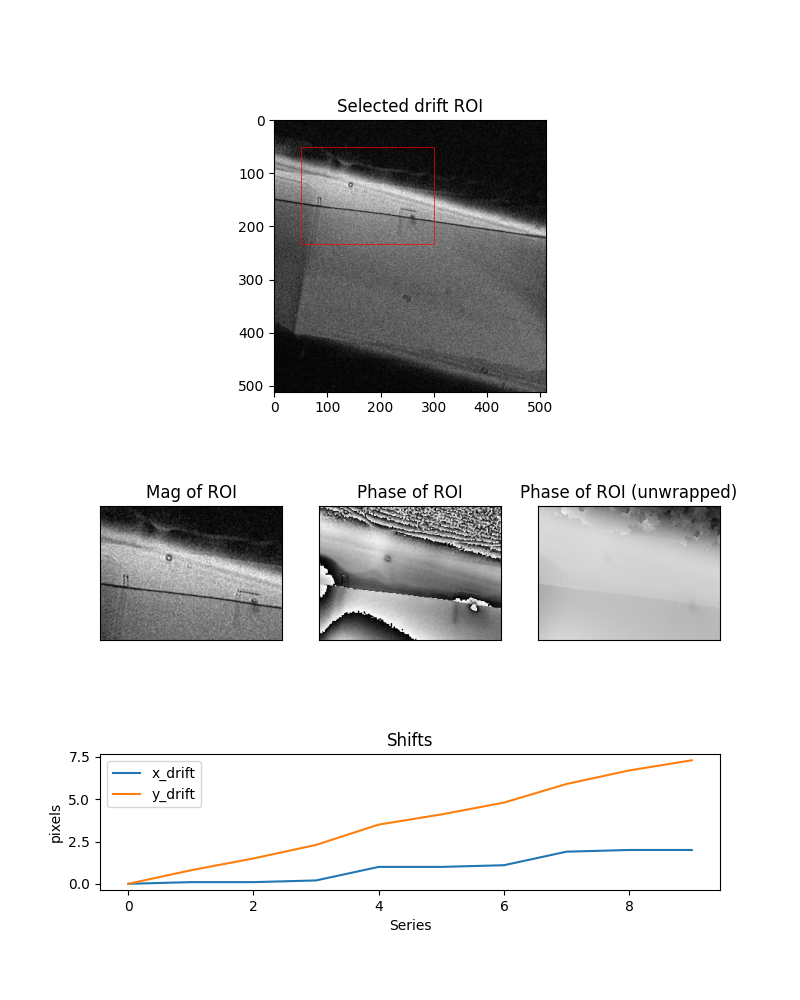

In [13]:
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.5])
ax0 = fig.add_subplot(gs[0, :])  # First row spanning all 3 columns
ax1 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax2 = fig.add_subplot(gs[1, 1])  # Second row, second column
ax3 = fig.add_subplot(gs[1, 2])  # Second row, third column
ax4 = fig.add_subplot(gs[2, :])  # Third row spanning all 3 columns

ax0.imshow(np.abs(first_holo), cmap='gray')
ax0.set_title("Selected drift ROI")

rect = patches.Rectangle(
   (drift_roi[1].start, drift_roi[0].start),
    drift_roi[1].stop - drift_roi[1].start,
    drift_roi[0].stop - drift_roi[0].start,
    linewidth=0.5,
    edgecolor='red',
    facecolor='none',
)
ax0.add_patch(rect)

ax1.imshow(np.abs(align_crop), cmap='gray')
ax1.set_title("Mag of ROI")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(np.angle(align_crop), cmap='gray')
ax2.set_title("Phase of ROI")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(unwrap_phase(np.angle(align_crop)), cmap='gray')
ax3.set_title("Phase of ROI (unwrapped)")
ax3.set_xticks([])
ax3.set_yticks([])

ax4.plot(shifts[:, 0], label = "x_drift")
ax4.plot(shifts[:, 1], label = "y_drift")
ax4.set_title("Shifts")
ax4.set_xlabel("Series")
ax4.set_ylabel("pixels")
ax4.legend()

With a good alignment, the following plot should be mostly noise, and not contain significant contrast from the sample:

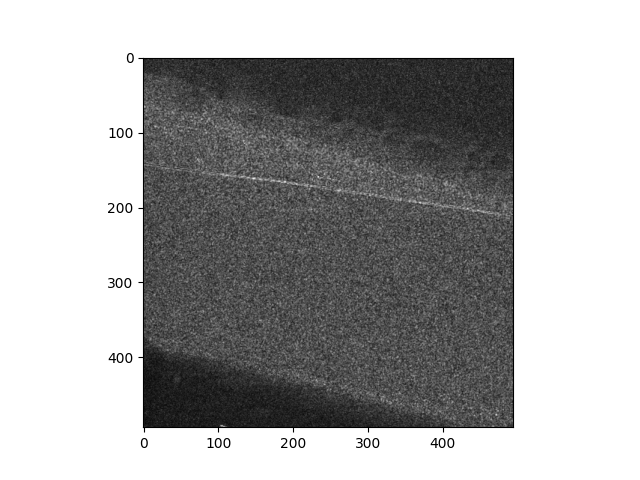

In [14]:
fig, ax = plt.subplots()
ax.imshow(stack_alignment_quality(aligned_stack, shifts), cmap='grey')

### Phase offset correction

In [15]:
mean_holo = np.sum(aligned_stack, axis=0)
mean_holo_corrected, phase_offsets, _ = phase_offset_correction(aligned_stack)
mean_phase_unwrapped = unwrap_phase(np.angle(mean_holo_corrected))

Text(0.5, 0, 'Series')

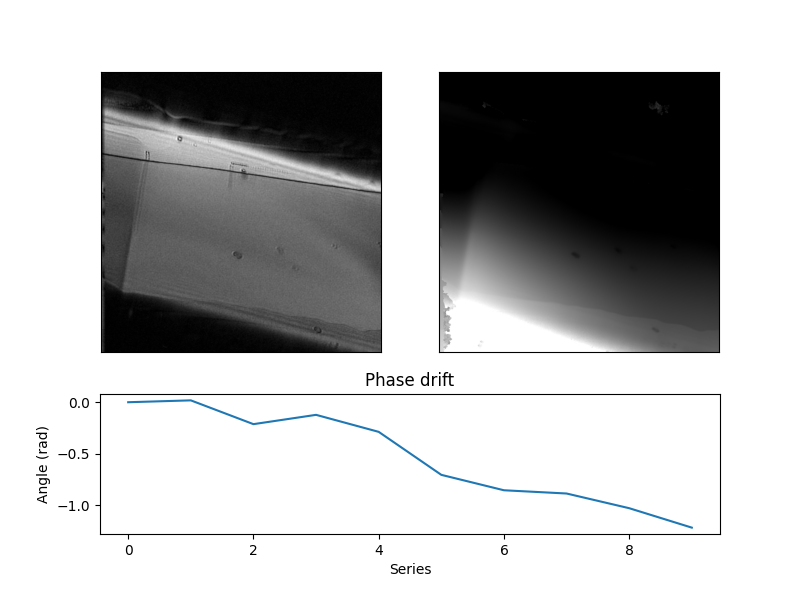

In [16]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5])
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
ax4 = fig.add_subplot(gs[1, :])  # Second row spanning all 3 columns

ax1.imshow(np.abs(mean_holo_corrected), cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(unwrap_phase(np.angle(mean_holo_corrected)), cmap='gray', vmax=48, vmin=-5)
ax2.set_xticks([])
ax2.set_yticks([])

ax4.plot(np.angle(phase_offsets))
ax4.set_title("Phase drift")
ax4.set_ylabel("Angle (rad)")
ax4.set_xlabel("Series")

## Step 3: Visualization and other corrections

### Rotation correction

In [17]:
rotation = 8
mean_phase_unwrapped_r = rotate(mean_phase_unwrapped, angle=rotation)
mean_phase_unwrapped_cropped = mean_phase_unwrapped_r[127:427, 32:427]  # crop to sample region

### Phase ramp compensation

In [18]:
ramp_roi = np.s_[0:42, 106:213]
mean_phase_compensated, _, _ = remove_phase_ramp(img=mean_phase_unwrapped_cropped, roi=ramp_roi)

### Visualization

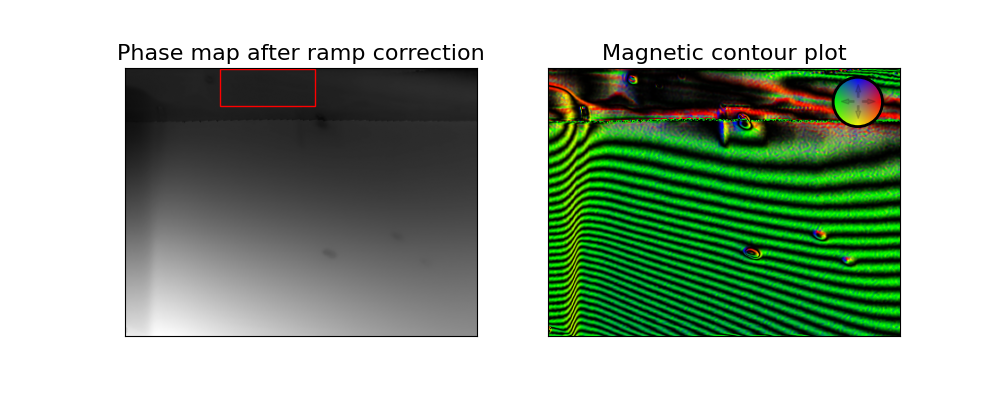

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(mean_phase_compensated, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Phase map after ramp correction", fontsize=16)

# show the ramp compensation ROI:
rect = patches.Rectangle(
    (ramp_roi[1].start, ramp_roi[0].start),
    ramp_roi[1].stop - ramp_roi[1].start,
    ramp_roi[0].stop - ramp_roi[0].start,
    linewidth=1,
    edgecolor='red',
    facecolor='none',
)
ax[0].add_patch(rect)

ax[1].set_title("Magnetic contour plot", fontsize=16)
ax[1].set_xticks([])
ax[1].set_yticks([])
plot_mag_induction(mean_phase_compensated, axis=ax[1], binning=1)